In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

from os.path import join, exists

import numpy as np
import matplotlib.pyplot as plt
from h5py import File
import scienceplots

import candel
from candel import plot_corner_from_hdf5, read_samples

from utils import *


%matplotlib inline
%load_ext autoreload
%autoreload 2


COLS = "#1be7ffff", "#6eeb83ff", "#e4ff1aff", "#ffb800ff", "#ff5714ff", "#9b5de5ff",

config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config.toml"
config = candel.load_config(config_path, )
# root = join("/Users/rstiskalek/Projects/CANDEL/", "results", "dH0")

### Figure: Redshift distribution comparison

In [2]:
import seaborn as sns
from candel import SPEED_OF_LIGHT


with File("/Users/rstiskalek/Projects/CANDEL/data/2MTF/PV_compilation.hdf5", 'r') as f:
    SFI = {}
    for key in f["SFI_gals"].keys():
        SFI[key] = f["SFI_gals"][key][...]

    TWOMTF = {}
    for key in f["2MTF"].keys():
        TWOMTF[key] = f["2MTF"][key][...]

    FOUNDATION = {}
    for key in f["Foundation"].keys():
        FOUNDATION[key] = f["Foundation"][key][...]

    LOSS = {}
    for key in f["LOSS"].keys():
        LOSS[key] = f["LOSS"][key][...]



with File("/Users/rstiskalek/Projects/CANDEL/data/CF4/CF4_TFR.hdf5", 'r') as f:
    CF4_TFR = {}
    grp = f["cf4"]
    for key in grp.keys():
        CF4_TFR[key] = grp[key][...]

    RA = grp["RA"][...] * 360 / 24
    CF4_TFR["RA"] = RA
    CF4_TFR["DEC"] = grp["DE"][...]

    l, b = candel.radec_to_galactic(CF4_TFR["RA"], CF4_TFR["DE"])
    m = np.abs(b) > 7.5
    for key in CF4_TFR.keys():
        CF4_TFR[key] = CF4_TFR[key][m]

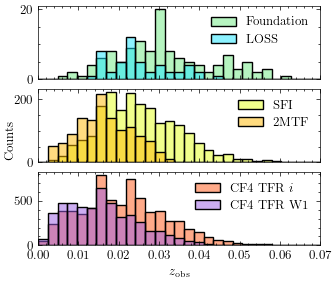

In [12]:
cols = COLS

with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10/3, 3), sharex=True)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    bins = np.linspace(0, 0.07, 30)
    alpha = 0.5
    edge_width = 1.0

    # First row: Foundation and LOSS
    sns.histplot(FOUNDATION["z_CMB"], bins=bins, stat="count", alpha=alpha, label="Foundation", color=cols[1], edgecolor="black", ax=axes[0], linewidth=edge_width)
    sns.histplot(LOSS["z_CMB"], bins=bins, stat="count", alpha=alpha, label="LOSS", color=cols[0], edgecolor="black", ax=axes[0], linewidth=edge_width)
    axes[0].set_ylabel(None)
    axes[0].legend()

    # Second row: 2MTF and SFI
    sns.histplot(SFI["z_CMB"], bins=bins, stat="count", alpha=alpha, label="SFI", color=cols[2], edgecolor="black", ax=axes[1], linewidth=edge_width)
    sns.histplot(TWOMTF["z_CMB"], bins=bins, stat="count", alpha=alpha, label="2MTF", color=cols[3], edgecolor="black", ax=axes[1], linewidth=edge_width)
    axes[1].set_ylabel(None)
    axes[1].legend()

    # Third row: CF4 samples
    m_i = CF4_TFR["i"] > 5
    sns.histplot(CF4_TFR["Vcmb"][m_i] / SPEED_OF_LIGHT, 
                 bins=bins, stat="count", alpha=alpha, label=catalogue2label("CF4_TFR_i"), color=cols[4], edgecolor="black", ax=axes[2], linewidth=edge_width)
    m_w1 = CF4_TFR["w1"] > 5
    sns.histplot(CF4_TFR["Vcmb"][m_w1] / SPEED_OF_LIGHT, 
                 bins=bins, stat="count", alpha=alpha, label=catalogue2label("CF4_TFR_w1"), color=cols[5], edgecolor="black", ax=axes[2], linewidth=edge_width)
    axes[2].set_xlabel(r"$z_{\rm obs}$")
    axes[2].set_ylabel(None)
    axes[2].legend()

    fig.text(0.03, 0.5, "Counts", va='center', ha='center', rotation='vertical')

    # Adjust layout
    plt.xlim(0, 0.07)
    plt.tight_layout(w_pad=0.2, h_pad=0.2)
    plt.savefig(f"/Users/rstiskalek/Downloads/zcmb_dist.pdf", dpi=450)
    plt.show()

### Figure: LOS comparison

In [24]:
from astropy.coordinates import angular_separation

rootdir = "/Users/rstiskalek/Projects/CANDEL/data/CF4"
RA_virgo = np.deg2rad(candel.hms_to_degrees(12, 27)),
dec_virgo = np.deg2rad(candel.dms_to_degrees(12, 43))
dist_virgo = 16.5 * 0.73  # Mpc/h

k = None
data = {}
reconstructions = ["Carrick2015", "Lilow2024", "CF4"]

for reconstruction in reconstructions:
    with File(join(rootdir, f"los_CF4_TFR_{reconstruction}.hdf5"), 'r') as f:
        if k is None:
            RA = np.deg2rad(f["RA"][...])
            dec = np.deg2rad(f["dec"][...])
            angdist = angular_separation(RA, dec, RA_virgo, dec_virgo)
            k = np.argmin(angdist)

        r = f["r"][...]
        rho = f["los_density"][:, k, :]
        vel = f["los_velocity"][:, k, :]

        if reconstruction == "Carrick2015":
            vel *= 0.43

        data[reconstruction] = [r, rho, vel]
    

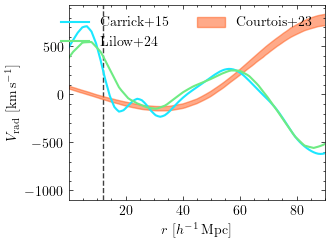

In [26]:
with plt.style.context("science"):
    fig, ax = plt.subplots()
    lw = plt.rcParams["lines.linewidth"]

    for simname in reconstructions:
        r, rho, vel = data[simname]  # vel: (nsamples, nr)
        y = vel

        col = simname2color(simname)
        if vel.shape[0] > 1:
            ylow, yhigh = np.percentile(y, [16, 84], axis=0)
            ax.fill_between(r, ylow, yhigh, alpha=0.5,
                            label=simname2label(simname), color=col)
        else:
            ax.plot(r, y[0], lw=1.5 * lw, label=simname2label(simname),
                    color=col)

    ax.set_xlabel(r"$r~[h^{-1}\,\mathrm{Mpc}]$")
    ax.set_ylabel(r"$V_{\rm rad}~[\mathrm{km}\,\mathrm{s}^{-1}]$")

    ax.set_xlim(r.min(), 90)
    # ax.set_ylim(-800, 1100)

    ax.axvline(dist_virgo, zorder=0, c="k", ls="--", alpha=0.75)

    ax.legend(ncols=2, loc="upper right")

    fig.tight_layout()
    plt.show()